In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = datasets.load_boston()
X = torch.tensor(data['data'], dtype=torch.float32)
y = torch.tensor(data['target'], dtype=torch.float32)
N, F = X.shape

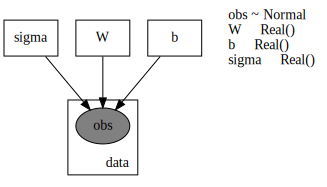

In [4]:
class FrequentistModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroParam(torch.randn(F))
        self.b = pyro.nn.PyroParam(torch.ones(1))
        self.sigma = pyro.nn.PyroParam(torch.ones(1), constraint=constraints.positive)

    def forward(self, X, y=None):
        mean = X @ self.W + self.b

        with pyro.plate("data", len(X)):
            return pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)

model = FrequentistModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [5]:
for i in range(3):
    print(model(X)[:5])

tensor([963.0043, 835.0921, 811.4755, 748.2012, 759.6595],
       grad_fn=<SliceBackward0>)
tensor([962.8970, 836.6730, 811.4534, 747.3740, 759.7141],
       grad_fn=<SliceBackward0>)
tensor([961.7648, 833.0337, 811.4817, 748.9583, 758.6625],
       grad_fn=<SliceBackward0>)


In [6]:
dist.Normal(0, 1).expand([F]).sample()

tensor([-1.4587, -1.4416,  0.2220, -1.1901, -1.0961,  1.4910,  0.2308,  0.5283,
        -0.6577, -1.8621, -0.8932, -1.9253,  0.1933])

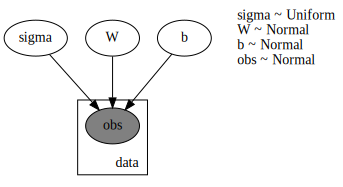

In [7]:
class BayesianModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroSample(dist.Normal(0, 10).expand([F]).to_event(1))
        self.b = pyro.nn.PyroSample(dist.Normal(20, 10))
        self.sigma = pyro.nn.PyroSample(dist.Uniform(0, 10))

    def forward(self, X, y=None):
        sigma = self.sigma   
        mean = X @ self.W + self.b
        
        with pyro.plate("data", N):
            return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

model = BayesianModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [8]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

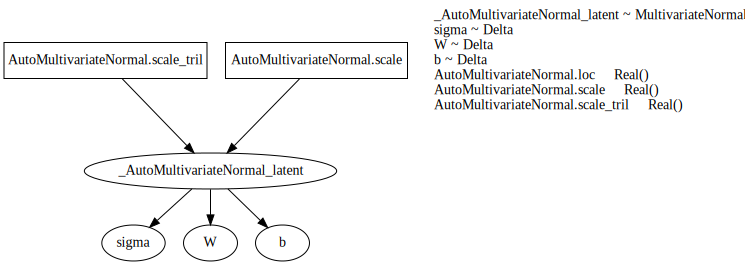

In [9]:
pyro.render_model(guide, model_args=(X, y), render_distributions=True, render_params=True)

In [10]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title(f'Min loss: {min(losses)}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

In [11]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for i in range(10_000):
    loss = svi.step(X, y)
    losses.append(loss)

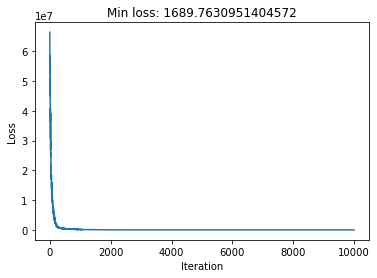

In [12]:
plot_losses(losses)

In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

W [-1.0727254   1.2309055  -0.23294568  0.2014096  -0.6464834   0.6109691
  1.2684672  -0.22218367 -1.8272096   2.2635634   0.97357374  0.4350934
 -0.03726688]
b [1.]
sigma [1.]
AutoMultivariateNormal.loc [ 1.7929764e+00 -1.2491057e-01  9.2413887e-02 -1.1274530e-01
  3.2589767e+00 -1.7502338e+00  1.8315330e+00 -1.6546703e-03
 -1.7622135e+00  2.6402700e-01 -1.9186221e-02 -1.1462539e-01
  1.1008131e-02 -7.3051947e-01  3.2030224e+01]
AutoMultivariateNormal.scale [0.08819456 0.05827638 0.02482866 0.09132876 1.406046   1.8537871
 0.19119953 0.03526368 0.18887578 0.06653836 0.01204742 0.11818202
 0.01404831 0.07334422 0.6834339 ]
AutoMultivariateNormal.scale_tril [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.96262953e-03  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  

In [14]:
with pyro.plate('samples', 1_000, dim=-1):
    samples = guide(X)

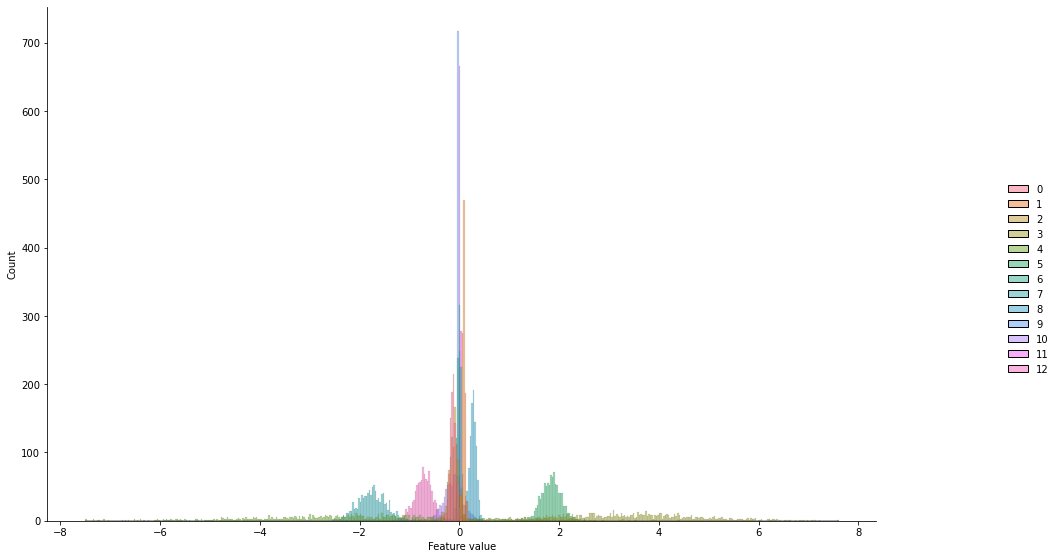

In [15]:
g = sns.displot(samples['W'].detach().numpy())
g.fig.set_figheight(8)
g.fig.set_figwidth(16)
plt.xlabel('Feature value');

In [16]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)
svi_samples = predictive(X)
svi_y = svi_samples["obs"]

In [17]:
model.eval()
trace = torch.jit.trace(model, X)

In [18]:
print(trace.code)

def forward(self,
    X: Tensor) -> Tensor:
  rand = torch.rand(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _0 = torch.mul(rand, torch.sub(CONSTANTS.c0, CONSTANTS.c1))
  _1 = torch.add(CONSTANTS.c1, _0)
  _2 = torch.zeros([13], dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _3 = torch.ones([13], dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  eps = torch.normal(_2, _3)
  _4 = torch.add(CONSTANTS.c3, torch.mul(eps, CONSTANTS.c2))
  _5 = torch.matmul(X, _4)
  _6 = torch.zeros(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _7 = torch.ones(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  eps0 = torch.normal(_6, _7)
  _8 = torch.add(CONSTANTS.c4, torch.mul(eps0, CONSTANTS.c0))
  _9 = torch.add(_5, _8)
  subsample = torch.arange(506, dtype=None, layout=0, device=torch.device("cpu"), pin_memory=False)
  _1

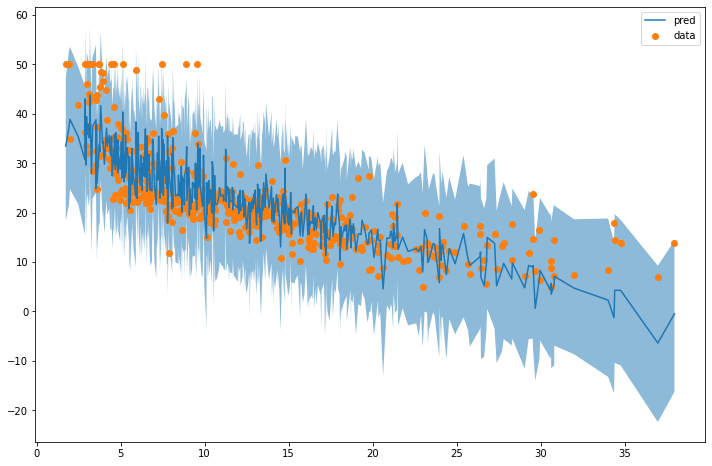

In [19]:
preds = pd.DataFrame({
    'X': X[:, -1],
    'y_mean': svi_y.mean(0).detach().cpu().numpy(),
    'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
    'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
    'true_y': y,
})
preds = preds.sort_values('X')

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(preds['X'], preds['y_mean'], label='pred')
ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
ax.scatter(preds['X'], preds['true_y'], label='data')
ax.legend();

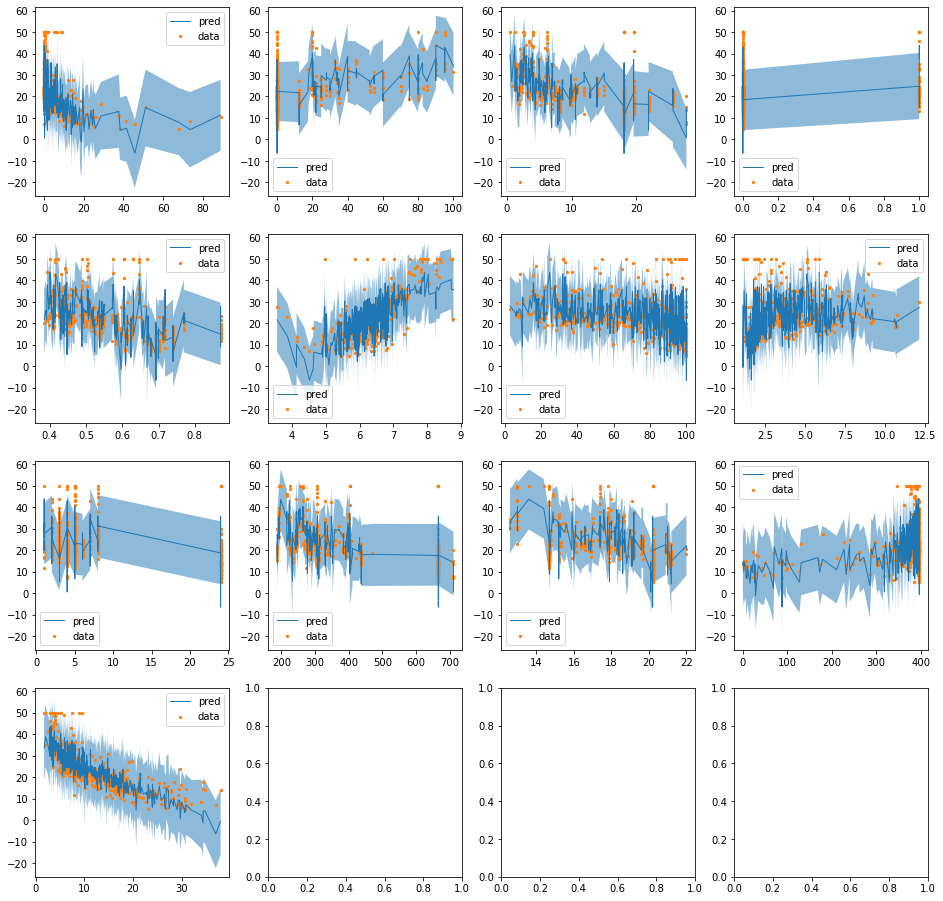

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i in range(F):
    preds = pd.DataFrame({
        'X': X[:, i],
        'y_mean': svi_y.mean(0).detach().cpu().numpy(),
        'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
        'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
        'true_y': y,
    }).sort_values('X')
    ax = axes[i // 4][i % 4]
    ax.plot(preds['X'], preds['y_mean'], linewidth=1, label='pred')
    ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
    ax.scatter(preds['X'], preds['true_y'], s=5, label='data')
    ax.legend();